In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Init

In [175]:
device = "cuda" if torch.cuda.is_available() else "cpu"
configuration = BertConfig()
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
args = {
        "device" : device,
        "data_dir" : r'../data/filtered_reviews_with_split.pkl',
        "data_chunks_dir" : r'../data/chunks',
        "emb_dim" : 768,
        "max_word" : 25,
        "max_sentence" : 10,
        "max_group": 5, # exclude default group
        "max_review_user" : 20,
        "max_review_item" : 50,
        "epoch" : 5,
        "batch_size": 32,
        "bert_configuration" : configuration,
        "bert_model" : bert_model,
        "bert_tokenizer" : bert_tokenizer
    }

print("Device: ",device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device:  cuda


## Read Pickle

In [337]:
"""
Required dataframe format:
[column name]       [dtype]
AppID               int
UserID              int
Like                int
Review              String
"""
data = pd.read_pickle(r'../data/reviews_38158.pkl')
# Change dtype of columns in df
data.reset_index(drop=True, inplace=True)
data["UserID"] = data["UserID"].astype("int64")
data["AppID"] = data["AppID"].astype(int)
data["Like"] = data["Like"].astype(int)
"""
TODO dataframe format:
[column name]       [dtype]
SplitReview         list
LDA_group           list
SplitReview_emb     np.array
"""
# TODO Columns
data["SplitReview"] = ""
data["SplitReview_emb"]= ""
data["LDA_group"]= ""

print(data.dtypes)
print("---Once you've prepared the data, press {Run All} will do the rest---")
data

AppID               int32
UserID              int64
Like                int32
Review             object
SplitReview        object
SplitReview_emb    object
LDA_group          object
dtype: object
---Once you've prepared the data, press {Run All} will do the rest---


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,,,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
4,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,,,
...,...,...,...,...,...,...,...
38153,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
38154,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
38155,9160,76561197993676094,1,Just some random lvls,,,
38156,9160,76561198010396848,1,additional levels for Doom 2.,,,


# Filter data

In [338]:
too_p_app = []
for app in data["AppID"].unique():
    app_df = data[data["AppID"]==app]
    if ((len(app_df[app_df["Like"]==1]) / len(app_df)) >= 0.85) & (len(app_df)>100):
        too_p_app.append(app)
mask = data["AppID"].isin(too_p_app)
data = data[~mask]
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,,,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
4,730,76561198123845513,0,[h1] This really doesn't have the feel of spor...,,,
...,...,...,...,...,...,...,...
38153,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
38154,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
38155,9160,76561197993676094,1,Just some random lvls,,,
38156,9160,76561198010396848,1,additional levels for Doom 2.,,,


In [339]:
# Drop user of high negative review ratio 
for user in set(data["UserID"]):
    user_df = data[data["UserID"]==user]
    if data['UserID'].value_counts()[user] < 25:
        data = data.drop(user_df.index)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561197969379991,1,wingman is fun with friends.,,,
1,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
2,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
3,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
4,730,76561198066952727,0,too many inconsistencies to make this a good c...,,,
...,...,...,...,...,...,...,...
24557,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,,,
24558,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
24559,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
24560,9160,76561197993676094,1,Just some random lvls,,,


In [340]:
# BOBO
# 找憤世嫉俗的 user 。 76561198027267313 刪嗎 (15 正評 / 90 負評)
rating_matrix = data.pivot_table(index='UserID', columns='AppID', values='Like').fillna(0)
user_ids = data.UserID.unique()
pos_reviews_threshold = 15  # 理想是 25，才能確保 test 中有 5 個，但 App 會只剩23評論
trash_users = [ user_ids[uid] for uid in np.where( np.sum(rating_matrix.values, axis=1)<pos_reviews_threshold )[0] ]
data = data[ ~data['UserID'].isin(trash_users) ]
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
1,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
2,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
3,730,76561198066952727,0,too many inconsistencies to make this a good c...,,,
4,730,76561197982565433,0,Play with a bunch of kids who won't say the th...,,,
...,...,...,...,...,...,...,...
22890,9160,76561197992120094,0,Let me know if you can get it to work. I can't.,,,
22891,9160,76561197964009814,0,The most demonic and difficult user made level...,,,
22892,9160,76561197977081885,1,"More like, Masturbator Levels of Doom 2 AMIRIT...",,,
22893,9160,76561197993676094,1,Just some random lvls,,,


In [341]:
for app in set(data['AppID']):
    if data['AppID'].value_counts()[app] < 40:
        data = data.drop(data[data['AppID']==app].index)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561198118543045,0,"Awful, toxic community and annoying game play....",,,
1,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,,,
2,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,,,
3,730,76561198066952727,0,too many inconsistencies to make this a good c...,,,
4,730,76561197982565433,0,Play with a bunch of kids who won't say the th...,,,
...,...,...,...,...,...,...,...
17808,41060,76561198126975019,1,It starts in a unusual way dropping you off in...,,,
17809,41060,76561197961167439,0,Seriously I'm not sure why I talked myself int...,,,
17810,41060,76561197962324014,1,This is pretty much a stand-alone expansion ty...,,,
17811,41060,76561197977081885,1,NEED MORE MONEY FOR COKE\n,,,


In [342]:
# check the number of reviews for each user/item 
app_reviews = data['AppID'].value_counts()
user_reviews = data['UserID'].value_counts()
app_reviews, user_reviews

(204100    184
 552520    179
 287390    163
 12210     157
 203140    150
          ... 
 242880     40
 225320     40
 15750      40
 12130      40
 312840     40
 Name: AppID, Length: 278, dtype: int64,
 76561198046675266    128
 76561198062813911    113
 76561198126975019     87
 76561197970705552     87
 76561198161141911     86
                     ... 
 76561198082928668     15
 76561197964120751     15
 76561197968748110     14
 76561198007513026     14
 76561198037586730     14
 Name: UserID, Length: 625, dtype: int64)

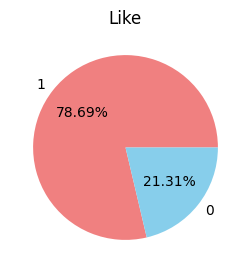

In [343]:
plt.figure(figsize=(3,3))
data['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Like')
plt.ylabel( '' )
plt.show()

# LDA Grouping

### 1. Split every review to sentences.  

In [347]:
import re

def review_to_sentences(review):
    """
    split review into sentences contained by a list
    param: review (String)
    output: sentences (list of word)
    """
    sentences = review.splitlines()
    sentences = list(filter(None, sentences))
    tmp = []
    for sent in sentences:
        sent = re.split(r' *[\.\?!][\'"\)\]]* *', sent)
        tmp.extend(sent)
    # delete sentence less than specific number of words
    sentences = list(filter(lambda x:len(x.split())>=5, tmp))
    return sentences

In [348]:
list_split_sentences =  [review_to_sentences(review) for review in data["Review"]]
data["SplitReview"] = list_split_sentences
empty = [i for i, x in enumerate(data["SplitReview"]) if x ==[]] # Delete data whose splitReview is empty list
data.drop(empty, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,
1,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,[After playing Counterstrike: Source for 12000...,,
2,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,"[Lots of fun to be had with this one, A lot of...",,
3,730,76561198066952727,0,too many inconsistencies to make this a good c...,[too many inconsistencies to make this a good ...,,
4,730,76561197982565433,0,Play with a bunch of kids who won't say the th...,[Play with a bunch of kids who won't say the t...,,
...,...,...,...,...,...,...,...
17328,41060,76561198126975019,1,It starts in a unusual way dropping you off in...,[It starts in a unusual way dropping you off i...,,
17329,41060,76561197961167439,0,Seriously I'm not sure why I talked myself int...,[Seriously I'm not sure why I talked myself in...,,
17330,41060,76561197962324014,1,This is pretty much a stand-alone expansion ty...,[This is pretty much a stand-alone expansion t...,,
17331,41060,76561197977081885,1,NEED MORE MONEY FOR COKE\n,[NEED MORE MONEY FOR COKE],,


### 2. LDA Grouping
#### asign each given sentence a group

In [349]:
# Modify LDA part from 趙儀
def stemmer_with_delete_stopword(split_sentences):
    vectorizer = TfidfVectorizer(stop_words = "english")
    stop_list = list(vectorizer.get_stop_words())
    porter_stemmer = PorterStemmer()
    all_stem_sents=[]
    for review in split_sentences:
        review_stem_list = []
        for sent in review:
            sent_stem_list =[]
            for word in sent.split(" "):
                if len(word)>2:
                    if word not in stop_list:
                        sent_stem_list.append(porter_stemmer.stem(word))
            review_stem_list.append(sent_stem_list)
        all_stem_sents.append(review_stem_list) 
    return all_stem_sents

def LDAGrouping(reviews, groups):
    all_sents = []
    for review in reviews:
        for sentence in review:
            all_sents.append(sentence)
    dictionary = corpora.Dictionary(all_sents)
    corpus = [dictionary.doc2bow(sent) for sent in all_sents]
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=groups)
    group_results = []
    for sents in reviews:
        single_corpus = [dictionary.doc2bow(sent) for sent in sents]
        sents_group_result = []
        for scores in lda_model.inference(single_corpus)[0]:
            # scores.argmax()+1 --> Retain group:0 for no meaning sentences
            sents_group_result.append(scores.argmax()+1)
        group_results.append(sents_group_result)

    return group_results, lda_model

def pad_and_trunc(group_results, *, max_sentence):
    #max number of sentences in a review
    result_list = []
    for i, result in enumerate(group_results):
        if len(result) >= max_sentence:
            result = result[:10]
        else:
            result.extend([0]*(max_sentence-len(result)))
        result_list.append(np.array(result).astype(int))
    return result_list

In [350]:
clean_reviews = stemmer_with_delete_stopword(data["SplitReview"].tolist())
group_list, lda_model = LDAGrouping(clean_reviews, args["max_group"]) # Training might takes a little bit time 
pad_group_list = pad_and_trunc(group_list, max_sentence=args["max_sentence"])
data["LDA_group"] = pad_group_list
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,730,76561198118543045,0,"Awful, toxic community and annoying game play....","[Awful, toxic community and annoying game play...",,"[5, 3, 0, 0, 0, 0, 0, 0, 0, 0]"
1,730,76561197971801273,0,After playing Counterstrike: Source for 12000+...,[After playing Counterstrike: Source for 12000...,,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,730,76561198084359238,1,Lots of fun to be had with this one. A lot of ...,"[Lots of fun to be had with this one, A lot of...",,"[4, 3, 4, 2, 0, 0, 0, 0, 0, 0]"
3,730,76561198066952727,0,too many inconsistencies to make this a good c...,[too many inconsistencies to make this a good ...,,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,730,76561197982565433,0,Play with a bunch of kids who won't say the th...,[Play with a bunch of kids who won't say the t...,,"[2, 3, 5, 4, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
17328,41060,76561198126975019,1,It starts in a unusual way dropping you off in...,[It starts in a unusual way dropping you off i...,,"[5, 2, 3, 0, 0, 0, 0, 0, 0, 0]"
17329,41060,76561197961167439,0,Seriously I'm not sure why I talked myself int...,[Seriously I'm not sure why I talked myself in...,,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
17330,41060,76561197962324014,1,This is pretty much a stand-alone expansion ty...,[This is pretty much a stand-alone expansion t...,,"[2, 3, 4, 0, 0, 0, 0, 0, 0, 0]"
17331,41060,76561197977081885,1,NEED MORE MONEY FOR COKE\n,[NEED MORE MONEY FOR COKE],,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [351]:
# Print topics trained from LDA
for idx, topic in lda_model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: game|the|sound|issu|music|graphic|make|it'|fix|realli|work|there|bug|lot|look|encount|visual|problem|chang|there'|anim|good|load|design|steam|annoy|ammo|great|quit|fairli
Topic: 1 
Words: game|play|it'|like|just|realli|good|thi|time|game,|don't|recommend|enjoy|say|feel|better|think|fun|bad|want|puzzl|the|worth|look|thing|i'm|year|stori|but|seri
Topic: 2 
Words: the|level|like|use|you|make|feel|world|game|charact|combat|just|love|design|fight|way|differ|thing|work|dark|lot|stori|boss|need|new|control|tri|there'|time|explor
Topic: 3 
Words: game|the|play|stori|control|hour|gameplay|fun|good|pretti|great|action|classic|best|time|platform|final|it'|thi|finish|complet|graphic|tomb|charact|cool|look|main|adventur|idea|modern
Topic: 4 
Words: enemi|time|use|weapon|player|just|shoot|you|kill|gun|level|war|like|mission|singl|crash|the|make|run|game|port|die|save|hit|fast|there|section|they|new|point


In [352]:
# Save the LDA grouping result
data.to_pickle(r"../data/filtered_review_group.pkl")

# Split Train Val Test

In [355]:
# Split train/val/test data by user case
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
for app in set(data["AppID"]):
    single_user_data = data[data["AppID"]==app]
    single_user_data_train = single_user_data[:int(len(single_user_data)*train_ratio)]
    single_user_data_val = single_user_data[int(len(single_user_data)*train_ratio):int(len(single_user_data)*(train_ratio+val_ratio))]
    single_user_data_test = single_user_data[int(len(single_user_data)*(train_ratio+val_ratio)):]
    train_df = pd.concat([train_df, single_user_data_train], axis=0)
    val_df = pd.concat([val_df, single_user_data_val], axis=0)
    test_df = pd.concat([test_df, single_user_data_test], axis=0)
len(train_df), len(val_df), len(test_df), len(train_df)+len(val_df)+len(test_df)

(12011, 1709, 3613, 17333)

In [353]:
# import random
# from sklearn.model_selection import train_test_split

# SEED = 21
# random.seed(SEED)

# train_ratio = 0.7
# val_ratio = 0.1
# test_ratio = 0.2

# train_app = random.sample(set(data["AppID"]), int(len(set(data["AppID"]))*train_ratio))
# test_app = list(set(data["AppID"])-set(train_app))
# val_app = random.sample(test_app, int(len(set(data["AppID"]))*val_ratio))
# test_app = list(set(test_app)-set(val_app))

# train_mask = data["AppID"].isin(train_app)
# train_df = data[train_mask]

# val_mask = data["AppID"].isin(val_app)
# val_df = data[val_mask]

# test_mask = data["AppID"].isin(test_app)
# test_df = data[test_mask]

# print(len(set(data["AppID"])))
# print(len(train_app), len(val_app), len(test_app))
# print(len(data), len(train_df)+len(val_df)+len(test_df), len(train_df), len(val_df), len(test_df))

In [354]:
# print("Train: ", len(train_df["UserID"].unique()), len(train_df["AppID"].unique())) 
# print("Val: ", len(val_df["UserID"].unique()), len(val_df["AppID"].unique())) 
# print("Test: ", len(test_df["UserID"].unique()), len(test_df["AppID"].unique())) 

In [357]:
# Exchange negative samples in testing with positive samples in training (劉老大要求test的label都要是1)
n_samples = len(test_df[test_df["Like"]==0])
n_sample_test = test_df[test_df["Like"]==0]
p_sample_train = train_df[train_df["Like"]==1].sample(n_samples)
test_df.drop(index=n_sample_test.index, inplace=True)
train_df.drop(index=p_sample_train.index, inplace=True)
test_df = pd.concat([test_df, p_sample_train])
train_df = pd.concat([train_df, n_sample_test])

print(len(n_sample_test))
print(len(train_df))
print(len(test_df))

593
12011
3613


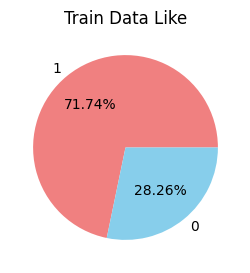

In [359]:
plt.figure(figsize=(3,3))
train_df['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Train Data Like')
plt.ylabel( '' )
plt.show()

### Adding negitive samples to Testing data 

In [360]:
# Build the false samples of testing
test_false_df = pd.DataFrame(columns=["AppID", "UserID", "Like"])
app_list = []
user_list = []
like_list = []
all_app = set(test_df["AppID"])
for user in set(test_df["UserID"]):
    user_have_item = list(test_df[test_df["UserID"]==user]["AppID"])
    for item in all_app:
        if (item in user_have_item):
            continue
        else:
            app_list.append(item)
            user_list.append(user)
            like_list.append(0)
test_false_df["AppID"] = app_list
test_false_df["UserID"] = user_list
test_false_df["Like"] = like_list
test_false_df

,AppID,UserID,Like
0,17410,76561198025398275,0
1,429570,76561198025398275,0
2,300550,76561198025398275,0
3,264710,76561198025398275,0
4,312840,76561198025398275,0
...,...,...,...
160402,248820,76561198016438265,0
160403,261110,76561198016438265,0
160404,782330,76561198016438265,0
160405,218620,76561198016438265,0


In [361]:
# Concat true and false sample into new test dataset
test_df = pd.concat([test_df, test_false_df])
test_df = shuffle(test_df)
test_df.reset_index(drop=True, inplace=True)
test_df

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,966330,76561198043609914,0,NaN,NaN,NaN,NaN
1,2630,76561197977081885,0,NaN,NaN,NaN,NaN
2,215530,76561198103358395,0,NaN,NaN,NaN,NaN
3,275850,76561198045783578,0,NaN,NaN,NaN,NaN
4,22120,76561198048974498,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
164015,49520,76561197983545926,0,NaN,NaN,NaN,NaN
164016,236870,76561197970329460,0,NaN,NaN,NaN,NaN
164017,952060,76561198202022263,0,NaN,NaN,NaN,NaN
164018,405830,76561197986406741,0,NaN,NaN,NaN,NaN


In [362]:
# Saving three types of dataframe
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.to_pickle(r"../data/train_df.pkl")
val_df.to_pickle(r"../data/val_df.pkl")
test_df.to_pickle(r"../data/test_df.pkl")

# Bert Encode

### 1. Init Bert and encode methods

In [363]:
def padding_to_tagert_dimension(input_tensor, sent_len, word_len, word_dim):
    """
    Set input_tensor to specified dim with zero padding, and flatten it
    ex: [3, 25, 768] -> [10, 25, 768] -> [250, 768]
    """
    target_emb = torch.zeros(sent_len, word_len, word_dim)
    target_emb[:input_tensor.size(dim=0), :, :] = input_tensor
    target_emb = torch.flatten(target_emb, start_dim=0, end_dim=1)
    
    return target_emb

def bert_encode(review_split, args):
    """
    Encode splitted review to bert embedding
    return embedding of review padded with zero
    """
    emb_list = []
    for i, sentence in enumerate(review_split):
        if i == args["max_sentence"]: break
        sentence_encode = args["bert_tokenizer"](
            sentence,
            return_attention_mask = True,
            max_length = args["max_word"],
            truncation = True,
            padding = "max_length",
            return_tensors = 'pt'
            )
        for k,v in sentence_encode.items():
            sentence_encode[k] = v.to(args["device"])
        with torch.no_grad():
            outputs = args["bert_model"](**sentence_encode)
        sentence_emb = outputs[2][-1]
        emb_list.append(sentence_emb)
    review_emb = torch.cat(emb_list, 0)
    pad_review_emb = padding_to_tagert_dimension(review_emb, args["max_sentence"], args["max_word"], args["emb_dim"])
    return pad_review_emb

### 2. Encode splited sentences and save into multiple chunks of H5DF

In [364]:
# Saving emb for each "user"
def save_each_bert_emb(data, *, col_name, target, max_review):
    user_set_len = len(set(data[col_name]))
    for i, indie in enumerate(set(data[col_name])):
        print("執行%s進度: %d/%d\r"%(target, i+1, user_set_len), end="")
        user_data = data[data[col_name]==indie]
        for index, review in zip(user_data.index, user_data["SplitReview"]):
            review_emb = np.asarray(bert_encode(review, args))
            user_data.at[index, "SplitReview_emb"] = review_emb
            user_data[["SplitReview_emb", "LDA_group", "Like"]][:max_review].to_pickle(f'../data/{target}_emb/{indie}.pkl')

In [365]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
save_each_bert_emb(data, col_name="UserID", target="user", max_review=args["max_review_user"])

In [366]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
# Can't store all emb into one df, so it has to be run twice 
save_each_bert_emb(data, col_name="AppID", target="item", max_review=args["max_review_item"])

### 3. Show Bert Encode Result

In [367]:
tmp = pd.read_pickle(r"../data/item_emb/50620.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([50, 250, 768])

In [369]:
tmp = pd.read_pickle(r"../data/user_emb/76561197983545926.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([20, 250, 768])

# Matrix Factorization

In [370]:
mf_df = pd.read_pickle(r"../data/filtered_review_group.pkl")
mf_df = mf_df[['AppID', 'UserID', 'Like']]
mf_df['Interacted'] = 1
mf_df

,AppID,UserID,Like,Interacted
0,730,76561198118543045,0,1
1,730,76561197971801273,0,1
2,730,76561198084359238,1,1
3,730,76561198066952727,0,1
4,730,76561197982565433,0,1
...,...,...,...,...
17328,41060,76561198126975019,1,1
17329,41060,76561197961167439,0,1
17330,41060,76561197962324014,1,1
17331,41060,76561197977081885,1,1


In [371]:
# Modify MF From 裴伯儀
def train_test_random_split(df):
    app_ids = list(df.columns)
    user_ids = list(df.index)
    user_set = {}
    for user_id in user_ids:
        interacted_items = [app_ids[idx] for idx in df.loc[user_id].values.nonzero()[0].tolist()]
        user_set[user_id] = interacted_items
    return user_set

def get_trainVector(df, user_set):
    business_ids = list(df.columns)
    user_ids = list(df.index)
    return [ [1 if business_id in user_set[user_id] else 0 for business_id in business_ids ] for user_id in user_ids]

def matrix_factorization(matrix, trainVector):
    # n_components is embedding dimension, vervose=1 shows the training process
    model = NMF(n_components=128, init='random', random_state=0, verbose=0)
    user_embeddings = model.fit_transform(trainVector*matrix.values)
    encoded_user_embeddings = np.asarray(user_embeddings, dtype=np.float32)
    app_embeddings = model.components_.T
    encoded_app_embeddings = np.asarray(app_embeddings.astype('float32'))
    user_id_emb = dict(zip(matrix.index, encoded_user_embeddings))
    app_id_emb = dict(zip(matrix.columns, encoded_app_embeddings))
    
    return user_id_emb, app_id_emb

### Construct Rating Matrix and Interaction Matrix

In [372]:
interaction_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Interacted').fillna(0)
rating_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Like').fillna(0)
user_set = train_test_random_split(interaction_matrix)
trainVector = torch.tensor(get_trainVector(interaction_matrix, user_set)).to(torch.float32)

### Train MF Model

In [373]:
user_id_emb, app_id_emb = matrix_factorization(rating_matrix, trainVector)
len(user_id_emb), len(app_id_emb), next(iter(user_id_emb.values())).shape, next(iter(app_id_emb.values())).shape

(624, 278, (128,), (128,))

### Save MF Embedding

In [374]:
app_mf_df = pd.DataFrame()
app_mf_df["AppID"] = list(app_id_emb.keys())
app_mf_df["MF_emb"] = list(app_id_emb.values())
app_mf_df.to_pickle(r"../data/train_item_mf_emb.pkl")

user_mf_df = pd.DataFrame()
user_mf_df["UserID"] = list(user_id_emb.keys())
user_mf_df["MF_emb"] = list(user_id_emb.values())
user_mf_df.to_pickle(r"../data/train_user_mf_emb.pkl")

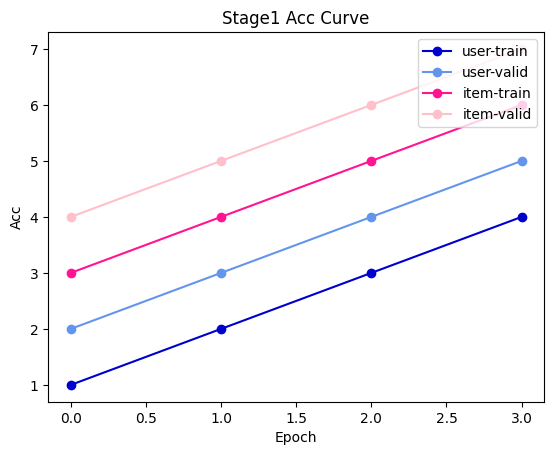

In [59]:
import matplotlib.pyplot as plt

t1 = [1,2,3,4]
v1 = [2,3,4,5]
t2 = [3,4,5,6]
v2 = [4,5,6,7]

# Plot test
def draw_acc_curve_stage1(u_train_acc, u_valid_acc, i_train_acc, i_valid_acc):
    plt.plot(u_train_acc, color="mediumblue", label="user-train", marker='o')
    plt.plot(u_valid_acc, color="cornflowerblue", label="user-valid", marker='o')
    plt.plot(i_train_acc, color="deeppink", label="item-train", marker='o')
    plt.plot(i_valid_acc, color="pink", label="item-valid", marker='o')
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title(f"Stage1 Acc Curve")
    # plt.savefig('output/plot/collab/acc_stage1_{}.png'.format(time.strftime("%m%d%H%M%S")))
    plt.show()

draw_acc_curve_stage1(t1,v1, t2, v2)

In [72]:
# tmp = pd.read_pickle(r'../data/reviews_21447.pkl')
# for user in set(tmp["UserID"]):
#     user_df = tmp[tmp["UserID"]==user]
#     if len(user_df[user_df["Like"]==0])/len(user_df) >= 0.7:
#         print(user, len(user_df[user_df["Like"]==0]), len(user_df)) 

76561197960282358 20 28
76561197986406741 22 26
76561198385097639 32 33
76561197994372073 32 32
76561198027267313 50 59
76561198101732759 54 72


In [210]:
# review_df = pd.read_pickle("../data/test_df.pkl")

# def get_empty_incidence_df():
#     user_index = set(review_df["UserID"])
#     app_index = set(review_df["AppID"])
#     incidence_df = pd.DataFrame(index=set(user_index), columns=set(app_index), dtype=np.float32)
#     incidence_df.fillna(0, inplace=True)
#     incidence_df.sort_index(inplace=True)
#     incidence_df = incidence_df.reindex(sorted(incidence_df.columns), axis=1)
#     return incidence_df

# def get_true_incidence_df():
#     user_index = set(review_df["UserID"])
#     incidence_df = get_empty_incidence_df()
#     for user in user_index:
#         user_df = review_df[review_df["UserID"]==user]
#         user_like_app_list = list(user_df[user_df["Like"]==1]["AppID"])
#         incidence_df.at[user, user_like_app_list] = 1
#     return incidence_df

# label_incidence_df = get_true_incidence_df()
# label_incidence_df

,400,2620,6920,6980,8870,12200,13520,15120,17330,22180,...,381210,427190,552520,614570,653530,692850,812140,1010750,1097150,1245620
76561197960282358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960425408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
76561197960440071,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960458021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960478145,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561199024836865,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199057481492,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199067595529,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76561199081818109,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
# from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score, average_precision_score
# import math

# def ndcg(y_true, y_pred, top_K=0):
#     # From 趙儀
#     ndcg_K = []
#     true_sum = 0

#     for i in range(y_pred.shape[0]):
#         top_indices = y_pred[i].argsort()[-top_K:][::-1] #每篇文章排名前Top K可能的tag index
#         true_num = np.sum(y_true[i, :])
#         true_sum += true_num
#         dcg = 0
#         idcg = 0
#         idcgCount = true_num
#         j = 0
#         for item in top_indices:
#             if y_true[i, item] == 1:
#                 dcg += 1.0/math.log2(j + 2)
#             if idcgCount > 0:
#                 idcg += 1.0/math.log2(j + 2)
#                 idcgCount = idcgCount-1
#             j += 1
#         if(idcg != 0):
#             ndcg_K.append(dcg/idcg)

#     return  np.mean(np.array(ndcg_K))

# TOP_N = 5
# predict_incidence_df = pd.read_pickle('output/history/probability_df.pkl')
# top_k_df = pd.read_pickle('output/history/topk_prediction_df.pkl')

# global_hit_10 = 0
# global_hit_5 = 0
# global_like = 0

# global_labels = []
# global_prediction = []

# # Calculate each score
# for user in predict_incidence_df.index:
    
#     # Data for scoring
#     user_topk_prediction = top_k_df.loc[user]
#     user_pred_prob = predict_incidence_df.loc[user]
    
#     user_label = label_incidence_df.loc[user]
#     user_like = user_label[user_label==1].keys()
#     user_topk_label = label_incidence_df.loc[user, user_topk_prediction]

#     # get 01 prediction from probability
#     pred_tensor = torch.tensor(user_pred_prob.values)
#     value, idx = pred_tensor.topk(k=TOP_N)
#     user_pred_binary = torch.zeros(pred_tensor.size())
#     user_pred_binary[idx] = 1 

#     global_like += len(user_like)
#     global_labels.append(user_label.tolist())
#     global_prediction.append(user_pred_binary.tolist())

#     # Top-10 hit ratio
#     user_top_10_label = user_topk_label[:10]
#     global_hit_10 += len(user_top_10_label[user_top_10_label==1])

#     # Top-5 hit ratio
#     user_top_5_label = user_topk_label[:5]
#     global_hit_5 += len(user_top_5_label[user_top_5_label==1])

# test_precision = precision_score(global_labels, global_prediction, zero_division=0, average="macro")
# test_recall = recall_score(global_labels, global_prediction, zero_division=0, average="macro")
# test_f1 = f1_score(global_labels, global_prediction, zero_division=0, average="macro")

# test_top_10_hr = global_hit_10 / global_like
# test_top_5_hr = global_hit_5 / global_like

# test_map = average_precision_score(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy())
# test_ndcg = ndcg(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy(), TOP_N)

# print(f"[ Test base ] precision@{TOP_N} = {test_precision:.4f}, recall@{TOP_N} = {test_recall:.4f}, f1@{TOP_N} = {test_f1:.4f}")
# print(f"[ Test base ] MAP@{TOP_N} = {test_map:.4f}, NDCG@{TOP_N} = {test_ndcg:.4f}, HR@10 = {test_top_10_hr:.4f}, HR@5 = {test_top_5_hr:.4f}")

[ Test base ] precision@5 = 0.0762, recall@5 = 0.1296, f1@5 = 0.0663
[ Test base ] MAP@5 = 0.1900, NDCG@5 = 0.2556, HR@10 = 0.3574, HR@5 = 0.2169


In [213]:
# for user in predict_incidence_df.index:
#     user_pred_prob = predict_incidence_df.loc[user]
#     user_label = label_incidence_df.loc[user]

#     pred_tensor = torch.tensor(user_pred_prob.values)
#     value, idx = pred_tensor.topk(k=TOP_N)
#     user_pred_binary = torch.zeros(pred_tensor.size())
#     user_pred_binary[idx] = 1 

#     print(user_pred_binary.tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 